In [46]:
# imports and loading
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1k/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
#log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

#A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
iM_table = pd.read_csv('../data/precise_1k/iM_table.csv', index_col = 0)
k_to_iM = {index : name for index, name in zip(iM_table.index, iM_table.name)}
M = pd.read_csv('../data/precise_1k/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
A = pd.read_csv('../data/precise_1k/A.csv', index_col = 0).rename(index = k_to_iM)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}


starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

In [47]:
M

,Sugar Diacid,Translation,ygdT,OxyR,FlhDC-2,Osmoprotectant,Glutamine,Sialic Acid,yqhI,ROS TALE Amp,...,Tryptophanase,crp KO-2,cyoB/ndh/nuoB KO-2,tpiA KO,Phage Shock,Glyoxylate,CCK-PGI Del,Acetate,Ile/Val,UC-8
b0002,-0.005367,-0.002423,0.010140,-0.001362,-0.017297,0.008631,-0.006491,0.092469,-0.010978,-0.003400,...,-0.012070,-0.008812,0.004996,0.008216,-0.002720,0.007874,-0.004350,-0.013319,0.009296,0.000891
b0003,0.006212,-0.001901,0.007207,0.000073,-0.004829,-0.003186,-0.011677,0.082103,0.011074,-0.004679,...,0.006683,-0.017798,0.000964,0.003273,0.010018,0.002132,-0.005826,-0.010836,-0.066654,-0.003513
b0004,0.010600,-0.002205,0.004961,-0.002289,-0.004938,-0.005587,-0.008127,0.080888,0.007511,0.003887,...,0.008132,-0.018105,-0.007763,0.009103,-0.002566,-0.007120,-0.005676,-0.002164,-0.060155,-0.007025
b0005,0.011520,0.008573,0.020449,-0.003123,0.002009,-0.026382,-0.016374,0.022484,0.007903,0.017561,...,-0.000139,0.001437,0.001827,-0.008113,0.065835,-0.019238,-0.001622,-0.009303,-0.069669,-0.004241
b0006,0.003482,-0.002293,-0.010146,0.140794,-0.001754,0.000974,0.023500,-0.017665,0.006247,-0.005761,...,0.017025,0.005473,-0.002252,0.002807,-0.030303,0.000805,0.028367,0.018293,-0.018444,-0.033624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,-0.003644,0.018245,-0.003134,0.004992,-0.000873,-0.021262,-0.012556,0.036707,-0.062935,0.016316,...,0.002969,-0.012892,0.024815,-0.000077,-0.004676,0.015222,0.011431,0.013733,0.011955,0.001203
b4748,0.010023,-0.030343,-0.000578,-0.002526,-0.000906,0.000805,0.007411,-0.021330,-0.013622,-0.034542,...,0.004057,-0.001059,-0.007595,0.002024,0.001573,-0.029301,-0.007873,0.021424,-0.001528,-0.000353
b4751,0.001082,0.013560,0.010030,-0.022409,0.006737,-0.012387,-0.002341,-0.010584,-0.015837,0.003776,...,-0.005873,-0.000560,0.008653,0.005759,0.029820,-0.004053,0.026769,0.020823,0.000414,-0.001453
b4755,-0.002204,-0.006527,0.003732,-0.000946,-0.009858,0.010553,-0.022747,0.003496,0.530162,0.000412,...,0.024388,0.003566,0.004696,-0.003552,0.002161,0.000556,-0.005656,0.021056,0.008180,0.021366


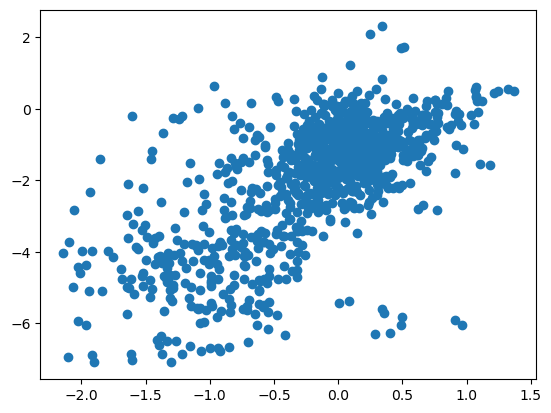

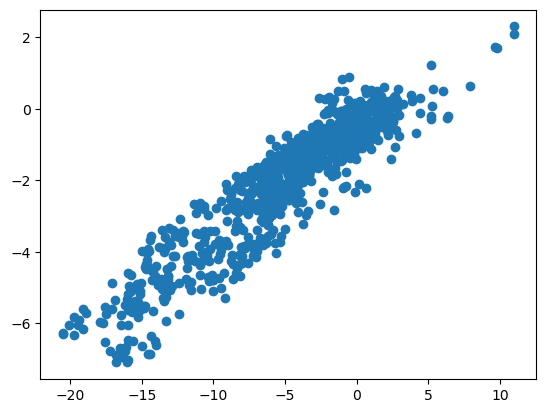

In [44]:
plt.scatter(log_tpm_df.loc[gene_to_b['argR']], log_tpm_df.loc[gene_to_b['argA']])
plt.show()

plt.scatter(A.loc['Arginine'], log_tpm_df.loc[gene_to_b['argA']])
plt.show()

In [31]:
A

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
0,0.048851,-0.048851,2.226245,2.238391,0.222740,0.383348,1.534940,1.480178,0.536021,0.167563,...,0.605951,3.969272,3.960774,3.431303,3.198403,3.865406,1.095074,2.575524,1.850326,2.035736
1,0.201055,-0.201055,-8.162122,-8.046208,1.633678,1.973262,-8.058080,-6.272859,-1.536470,-1.828831,...,2.416670,-1.187724,-1.626310,-1.492168,-0.436511,-1.004710,5.258995,-1.782148,-4.601815,-5.110518
2,-0.382475,0.382475,0.066040,-0.898701,-0.556961,-1.523642,0.039413,0.002855,0.256867,-1.890067,...,-1.885401,0.689130,1.997418,2.177559,1.459224,-3.110064,4.336594,0.626609,-0.166365,0.539555
3,0.130714,-0.130714,0.232581,-0.135165,-0.140487,-0.435341,-0.788937,-1.333850,0.255054,0.464381,...,-2.743285,-2.888544,-2.341820,-2.498864,-2.931448,-2.693465,-1.690293,-3.056924,-3.575826,-2.316941
4,-0.329000,0.329000,-5.319409,-5.196873,-7.144849,-6.758991,-5.930140,-5.934485,-1.775148,-3.070194,...,4.303118,1.626655,2.701441,1.840211,2.703303,1.862170,10.399505,-4.285524,2.349262,3.101853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.344877,-0.344877,5.450515,5.444039,-0.641401,-0.472477,5.557743,5.070821,0.423674,0.559522,...,1.180854,2.036347,2.514846,2.469912,2.064530,2.645660,0.830452,4.243346,2.047711,2.828812
197,0.077106,-0.077106,-0.260639,0.163570,1.030188,1.220775,-0.049178,0.392918,1.611484,1.699807,...,-0.360018,0.689914,1.350155,0.510417,1.075789,2.065799,-2.090274,0.143198,-0.551313,0.908994
198,0.575197,-0.575197,-2.476044,-2.875184,-0.756414,-0.251539,-1.737154,-1.652438,-1.304588,-1.319442,...,1.637433,5.259582,6.259438,5.784253,4.928517,4.221586,0.574095,12.177624,12.558275,12.767103
199,0.226627,-0.226627,1.699217,1.678226,-1.167426,-0.618004,2.100661,2.068120,-1.050492,-1.504338,...,0.388348,-1.066533,-0.469043,-1.736812,-0.701636,-0.657140,1.027797,-2.860252,-1.283872,-1.949882


In [28]:
log_tpm_df.loc[gene_to_b['argA']]

p1k_00001    4.712993
p1k_00002    4.842465
p1k_00003    5.011721
p1k_00004    4.991690
p1k_00005    4.360711
               ...   
p1k_01051    3.962340
p1k_01052    3.707681
p1k_01053    4.034239
p1k_01054    4.216939
p1k_01055    4.350536
Name: b2818, Length: 1035, dtype: float64